In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def find_similar_market_periods(csv_path, target_start, target_end, historical_start=None, 
                               historical_end=None, top_n=3, sampling_interval='1D'):
    """
    Find historical periods with similar price patterns to the target period.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file containing the data
    target_start : str
        Start date of the target period in format 'YYYY-MM-DD HH:MM:SS'
    target_end : str
        End date of the target period in format 'YYYY-MM-DD HH:MM:SS'
    historical_start : str, optional
        Start date of the historical search period
    historical_end : str, optional
        End date of the historical search period (must be < target_start)
    top_n : int
        Number of similar periods to return
    sampling_interval : str or int, optional
        Interval at which to sample start points. Can be:
        - A string like '1D' (daily), '1W' (weekly), etc. for time-based sampling
        - An integer for number of data points to skip between samples
    
    Returns:
    --------
    Tuple of (target_data, similar_periods)
    """
    # Load data
    df = pd.read_csv(csv_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    
    # Extract target period
    target_data = df[target_start:target_end]
    if len(target_data) == 0:
        raise ValueError(f"No data found between {target_start} and {target_end}")
    
    # Calculate target period length
    target_length = len(target_data)
    
    # Filter historical data range
    if historical_start is None:
        historical_start = df.index[0]
    else:
        historical_start = pd.to_datetime(historical_start)
        
    if historical_end is None:
        historical_end = pd.to_datetime(target_start) - pd.Timedelta(seconds=1)
    else:
        historical_end = pd.to_datetime(historical_end)
        if historical_end >= pd.to_datetime(target_start):
            historical_end = pd.to_datetime(target_start) - pd.Timedelta(seconds=1)
    
    # Get historical data only
    historical_df = df[historical_start:historical_end]
    
    print(f"Analyzing data from {historical_start} to {historical_end}")
    print(f"Looking for patterns similar to target period: {target_start} to {target_end} ({target_length} data points)")
    print(f"Sampling interval: {sampling_interval}")
    
    # Calculate target period returns and normalization
    target_returns = target_data['Close'].pct_change().fillna(0)
    target_normalized = (target_data['Close'] / target_data['Close'].iloc[0]) - 1
    
    # Initialize list to store similar periods
    similar_periods = []
    
    # Determine the sampling indices based on the sampling_interval
    if isinstance(sampling_interval, int):
        # Use fixed number of data points as interval
        sample_indices = range(0, len(historical_df) - target_length + 1, sampling_interval)
        print(f"Sampling every {sampling_interval} data points ({len(sample_indices)} total samples)")
    else:
        # Time-based resampling
        # Get all unique days (or other interval) in the historical data
        if sampling_interval == '1D':
            # Daily sampling - get one sample per trading day
            # Get unique dates and find the first occurrence of each
            unique_dates = historical_df.index.date
            unique_date_indices = []
            current_date = None
            for i, date in enumerate(unique_dates):
                if date != current_date:
                    unique_date_indices.append(i)
                    current_date = date
            sample_indices = [i for i in unique_date_indices if i <= len(historical_df) - target_length]
            print(f"Sampling at start of each trading day ({len(sample_indices)} total samples)")
        else:
            # Other time-based sampling (week, month, etc.)
            resampled = historical_df.resample(sampling_interval).first()
            # Map resampled index back to original dataframe indices
            sample_indices = []
            for ts in resampled.index:
                # Find the index in the original df closest to this timestamp
                indices = np.where(historical_df.index >= ts)[0]
                if len(indices) > 0 and indices[0] <= len(historical_df) - target_length:
                    sample_indices.append(indices[0])
            print(f"Sampling at {sampling_interval} interval ({len(sample_indices)} total samples)")
    
    if len(sample_indices) == 0:
        raise ValueError(f"No valid samples found with interval {sampling_interval}")
    
    # Slide through historical data using sample_indices
    for idx, i in enumerate(sample_indices):
        # Performance optimization - print progress every 5% of the way
        if idx % max(1, len(sample_indices) // 20) == 0:
            print(f"Progress: {idx}/{len(sample_indices)} ({idx/len(sample_indices)*100:.1f}%)")
        
        # Extract historical period
        window_start_idx = historical_df.index[i]
        window_end_idx = historical_df.index[min(i + target_length - 1, len(historical_df) - 1)]
        
        # Skip if we don't have enough data points
        if window_end_idx == historical_df.index[-1] and i + target_length > len(historical_df):
            continue
            
        window_data = historical_df.loc[window_start_idx:window_end_idx]
        
        # Skip if window has wrong length (could happen near boundaries)
        if len(window_data) != target_length:
            continue
        
        # Normalize window data
        window_normalized = (window_data['Close'] / window_data['Close'].iloc[0]) - 1
        
        # Calculate similarity metrics
        # 1. Correlation coefficient
        correlation, _ = pearsonr(target_normalized, window_normalized)
        
        # 2. Dynamic Time Warping distance
        distance, path = fastdtw(target_normalized.values.reshape(-1, 1), 
                                window_normalized.values.reshape(-1, 1),
                                dist=euclidean)
        # Normalize DTW distance by length
        normalized_distance = distance / target_length
        
        # 3. Volatility similarity
        target_vol = target_returns.std()
        window_returns = window_data['Close'].pct_change().fillna(0)
        window_vol = window_returns.std()
        vol_similarity = 1 - min(target_vol, window_vol) / max(target_vol, window_vol)
        
        # Calculate combined similarity score (higher is better)
        similarity_score = 0.6 * correlation - 0.3 * normalized_distance - 0.1 * vol_similarity
        
        similar_periods.append({
            'start_date': window_start_idx,
            'end_date': window_end_idx,
            'similarity_score': similarity_score,
            'correlation': correlation,
            'dtw_distance': normalized_distance,
            'volatility_ratio': target_vol / window_vol,
            'data': window_data
        })
    
    # Sort by similarity score (descending)
    similar_periods.sort(key=lambda x: x['similarity_score'], reverse=True)
    
    # Return top N periods
    return target_data, similar_periods[:top_n]

def plot_similar_periods(target_data, similar_periods):
    """Plot the target period alongside the most similar periods"""
    # Same as before
    n_periods = len(similar_periods)
    fig, axs = plt.subplots(n_periods + 1, 1, figsize=(14, 4 * (n_periods + 1)), sharex=False)
    
    # Plot target data
    target_normalized = (target_data['Close'] / target_data['Close'].iloc[0]) - 1
    axs[0].plot(target_normalized.index, target_normalized, 'b-', linewidth=2)
    axs[0].set_title(f'Target Period: {target_data.index[0].date()} to {target_data.index[-1].date()}')
    axs[0].set_ylabel('Normalized Returns')
    axs[0].grid(True)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Plot similar periods
    for i, period in enumerate(similar_periods):
        period_data = period['data']
        period_normalized = (period_data['Close'] / period_data['Close'].iloc[0]) - 1
        
        axs[i+1].plot(period_normalized.index, period_normalized, 'g-', linewidth=2)
        axs[i+1].set_title(f'Similar Period {i+1}: {period["start_date"].date()} to {period["end_date"].date()}\n'
                          f'Similarity: {period["similarity_score"]:.3f}, Correlation: {period["correlation"]:.3f}, '
                          f'DTW Distance: {period["dtw_distance"]:.3f}, Vol Ratio: {period["volatility_ratio"]:.3f}')
        axs[i+1].set_ylabel('Normalized Returns')
        axs[i+1].grid(True)
        axs[i+1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    return fig

def compare_market_periods(csv_path, target_start, target_end, historical_start=None, 
                         historical_end=None, top_n=3, sampling_interval='1D'):
    """
    Main function to find and visualize similar market periods
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file containing the data
    target_start : str
        Start date of the target period in format 'YYYY-MM-DD HH:MM:SS'
    target_end : str
        End date of the target period in format 'YYYY-MM-DD HH:MM:SS'
    historical_start : str, optional
        Start date of the historical search period
    historical_end : str, optional
        End date of the historical search period (must be < target_start)
    top_n : int
        Number of similar periods to return
    sampling_interval : str or int, optional
        Interval at which to sample start points. Can be:
        - A string like '1D' (daily), '1W' (weekly), etc. for time-based sampling
        - An integer for number of data points to skip between samples
    """
    # Time the execution
    import time
    start_time = time.time()
    
    # Find similar periods
    target_data, similar_periods = find_similar_market_periods(
        csv_path, target_start, target_end, 
        historical_start, historical_end, top_n, sampling_interval
    )
    
    # Print execution time
    execution_time = time.time() - start_time
    print(f"\nExecution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")
    
    # Print summary of similar periods
    print(f"Target Period: {target_data.index[0]} to {target_data.index[-1]}")
    print("\nTop Similar Periods:")
    for i, period in enumerate(similar_periods):
        print(f"{i+1}. {period['start_date']} to {period['end_date']}")
        print(f"   Similarity Score: {period['similarity_score']:.3f}")
        print(f"   Correlation: {period['correlation']:.3f}")
        print(f"   DTW Distance: {period['dtw_distance']:.3f}")
        print(f"   Volatility Ratio: {period['volatility_ratio']:.3f}")
    
    # Plot the periods
    fig = plot_similar_periods(target_data, similar_periods)
    plt.show()
    
    return target_data, similar_periods, execution_time

Analyzing 94827 data points from 2019-05-01 09:30:00 to 2021-04-30 16:00:00
Looking for patterns similar to target period: 2021-07-01 09:30:00 to 2021-08-01 16:00:00 (3864 data points)
Progress: 0/90964 (0.0%)
Progress: 909/90964 (1.0%)
Progress: 1818/90964 (2.0%)
Progress: 2727/90964 (3.0%)
Progress: 3636/90964 (4.0%)
Progress: 4545/90964 (5.0%)
Progress: 5454/90964 (6.0%)
Progress: 6363/90964 (7.0%)
Progress: 7272/90964 (8.0%)
Progress: 8181/90964 (9.0%)
Progress: 9090/90964 (10.0%)
Progress: 9999/90964 (11.0%)
Progress: 10908/90964 (12.0%)
Progress: 11817/90964 (13.0%)
Progress: 12726/90964 (14.0%)
Progress: 13635/90964 (15.0%)
Progress: 14544/90964 (16.0%)
Progress: 15453/90964 (17.0%)
Progress: 16362/90964 (18.0%)
Progress: 17271/90964 (19.0%)
Progress: 18180/90964 (20.0%)
Progress: 19089/90964 (21.0%)
Progress: 19998/90964 (22.0%)
Progress: 20907/90964 (23.0%)
Progress: 21816/90964 (24.0%)
Progress: 22725/90964 (25.0%)
Progress: 23634/90964 (26.0%)
Progress: 24543/90964 (27.0%)
P

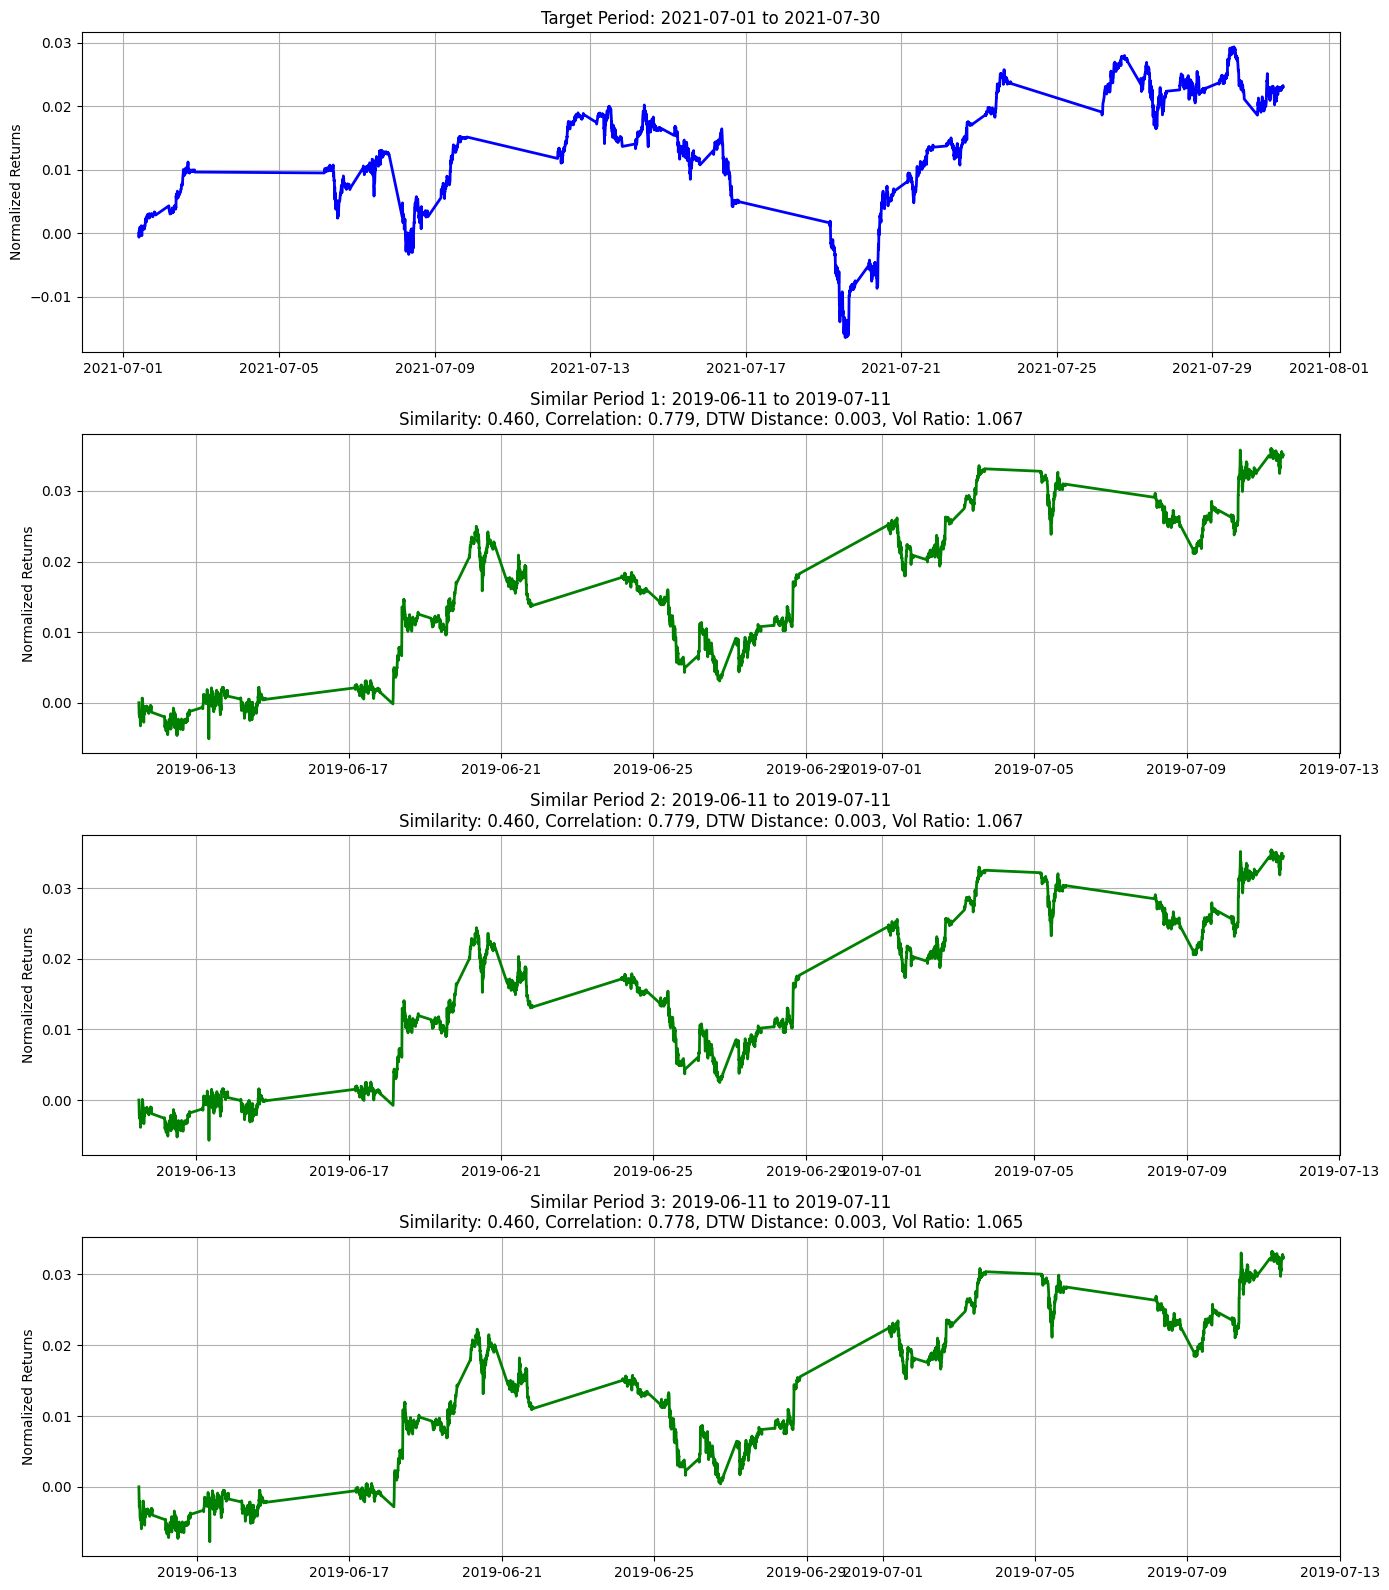

In [ ]:
# Example 1: Daily sampling (one test per day)
csv_path = "SPY_5M.csv"
target_start = "2021-05-01 09:30:00"
target_end = "2021-06-01 16:00:00"
historical_start = "2016-01-01 09:30:00"
historical_end = "2021-04-30 16:00:00"

target_data, similar_periods, execution_time = compare_market_periods(
    csv_path=csv_path,
    target_start=target_start,
    target_end=target_end,
    historical_start=historical_start,
    historical_end=historical_end,
    top_n=3,
    sampling_interval='1D'  # Check once per day
)

# Example 2: Weekly sampling
# target_data, similar_periods, execution_time = compare_market_periods(
#     csv_path=csv_path,
#     target_start=target_start,
#     target_end=target_end,
#     historical_start=historical_start,
#     historical_end=historical_end,
#     top_n=3,
#     sampling_interval='1W'  # Check once per week
# )

# # Example 3: Custom interval (every 78 data points, which is approximately one day in 5-minute data)
# target_data, similar_periods, execution_time = compare_market_periods(
#     csv_path=csv_path,
#     target_start=target_start,
#     target_end=target_end,
#     historical_start=historical_start,
#     historical_end=historical_end,
#     top_n=3,
#     sampling_interval=78  # Check every 78 data points (78 5-min bars ≈ 1 trading day)
# )